In [87]:
library(DBI)
library(ggplot2)
library(tidyverse)
library(caret)
library(scales)
library(ggsankey)
library(ggalluvial)

In [2]:
con <- dbConnect(
    RPostgres::Postgres(),
    dbname = 'npm_data', 
    user = 'data_analyzer',
)

In [16]:
# This takes about 40 seconds to load (when running on the VM!), and takes about 4GB of memory
df <- dbGetQuery(con, "
    select 
        instant_update, 
        update_days, 
        downstream_updated_req, 
        is_intro, 
        is_patch, 
        is_neutral, 
        downstream_package_id, 
        result_category,
        ty as update_type 
    from analysis.old_historic_solver_job_flow_info f
    inner join analysis.all_updates u on u.from_id = f.update_from_id and u.to_id = f.update_to_id
")

In [18]:
head(df)

,instant_update,update_days,downstream_updated_req,is_intro,is_patch,is_neutral,downstream_package_id,result_category,update_type
,<lgl>,<int>,<lgl>,<lgl>,<lgl>,<lgl>,<int64>,<chr>,<chr>
1,TRUE,0,FALSE,FALSE,FALSE,TRUE,2146078,Ok,bug
2,TRUE,0,FALSE,FALSE,FALSE,TRUE,2267449,Ok,bug
3,TRUE,0,FALSE,FALSE,FALSE,TRUE,2267468,Ok,bug
4,TRUE,0,FALSE,FALSE,FALSE,TRUE,2267466,Ok,bug
5,TRUE,0,FALSE,FALSE,FALSE,TRUE,2267475,Ok,bug
6,TRUE,0,FALSE,FALSE,FALSE,TRUE,2267468,Ok,minor


In [50]:
clean_df <- df %>% mutate(
    security_effect = ifelse(is_intro, 'introduces', ifelse(is_patch, 'patches', 'neutral')),
    developer_intervention = ifelse(downstream_updated_req, 'intervention', 'no intervention'),
    resolution = ifelse(result_category == 'Ok' & instant_update, 'instant update', ifelse(result_category == 'Ok', 'delayed update', ifelse(instant_update, 'WEIRD', 'deleted dependency')))
) %>% 
filter(resolution != "WEIRD") %>% # A small number of updates instantly have deleted dependencies. These are anomalies caused by circular dependencies. We ignore them.
filter(!(resolution == "instant update" & developer_intervention == "intervention")) %>% # A small number of updates are themselves the updates, due to circular dependencies. We ignore them.
select(security_effect, update_type, developer_intervention, resolution, update_days)

clean_df$update_type <- factor(as.character(clean_df$update_type), levels=c("bug", "minor", "major"))
clean_df$security_effect <- factor(clean_df$security_effect, levels=c("neutral", "patches", "introduces"))
clean_df$developer_intervention <- factor(clean_df$developer_intervention, levels=c("no intervention", "intervention"))
clean_df$resolution <- factor(clean_df$resolution, levels=c("instant update", "delayed update", "deleted dependency"))

In [51]:
clean_df %>% group_by(developer_intervention, resolution) %>% summarise(count = n())

`summarise()` has grouped output by 'developer_intervention'. You can override
using the `.groups` argument.


developer_intervention,resolution,count
<fct>,<fct>,<int>
no intervention,instant update,90262
no intervention,delayed update,606
no intervention,deleted dependency,59
intervention,delayed update,9030
intervention,deleted dependency,232


In [138]:
sec_percs <- clean_df %>% group_by(security_effect) %>% 
    summarise(count = n()) %>%
    mutate(per=paste0(round(count/sum(count)*100, 2), "%")) %>% 
    ungroup()
    
introduces_perc <- sec_percs %>% filter(security_effect == "introduces") %>% pull(per)
patches_perc <- sec_percs %>% filter(security_effect == "patches") %>% pull(per)
neutral_perc <- sec_percs %>% filter(security_effect == "neutral") %>% pull(per)


In [115]:
long_df <- clean_df %>% mutate(sec_effect2 = security_effect) %>% make_long(security_effect, update_type, developer_intervention, resolution, value=sec_effect2)

Warning message:
“attributes are not identical across measure variables;
they will be dropped”


In [116]:
long_df <- long_df %>% mutate(
    weight=ifelse(value == "introduces", 200, ifelse(value == "patches", 10, 1)),
    sec_effect2 = value
) %>% select(-value)

In [117]:
node_order <- c("neutral", "patches", "introduces", "bug", "minor", "major", "no intervention", "intervention", "instant update", "delayed update", "deleted dependency")
long_df$node <- factor(long_df$node, levels=node_order)
long_df$next_node <- factor(long_df$next_node, levels=node_order)
long_df$sec_effect2 <- factor(long_df$sec_effect2, levels=c("neutral", "patches", "introduces"))


In [152]:
long_df$x <- recode_factor(long_df$x, security_effect = "Security Effect", update_type = "Update Type", developer_intervention = "Developer Intervention", resolution = "Resolution")
long_df$next_x <- recode_factor(long_df$next_x, security_effect = "Security Effect", update_type = "Update Type", developer_intervention = "Developer Intervention", resolution = "Resolution")

In [153]:
levels(long_df$x)

[1] "Security Effect"        "Update Type"            "Developer Intervention"
[4] "Resolution"

In [154]:
head(long_df)

x,node,next_x,next_node,weight,sec_effect2
<fct>,<fct>,<fct>,<fct>,<dbl>,<fct>
Security Effect,neutral,Update Type,bug,1,neutral
Update Type,bug,Developer Intervention,no intervention,1,neutral
Developer Intervention,no intervention,Resolution,instant update,1,neutral
Resolution,instant update,NA,NA,1,neutral
Security Effect,neutral,Update Type,bug,1,neutral
Update Type,bug,Developer Intervention,no intervention,1,neutral


Saving 6.67 x 6.67 in image


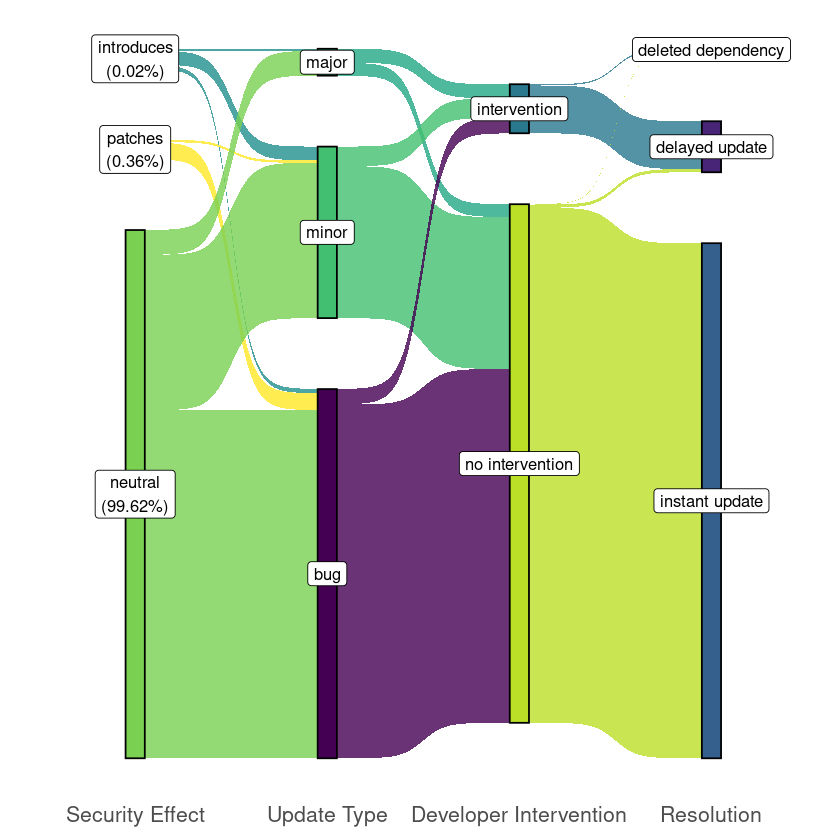

In [160]:
long_df %>% mutate(
    extra_lab = ifelse(node == "introduces", paste0("\n(", introduces_perc, ")"), ifelse(node == "patches", paste0("\n(", patches_perc, ")"), ifelse(node == "neutral", paste0("\n(", neutral_perc, ")"), "")))
) %>% ggplot( 
    aes(x = x, 
        next_x = next_x, 
        node = node, 
        next_node = next_node,
        fill = factor(node),
        value = weight,
        label = paste0(node, extra_lab))) +
    geom_sankey(flow.alpha = 0.8, node.color = 1) +
    geom_sankey_label(size = 3.5, color = 1, fill = "white") +
    # geom_text()
    scale_fill_viridis_d() +
    theme_sankey(base_size = 16) +
    labs(x = NULL) + 
    theme(legend.position = "none")

ggsave("plots/rq3/flow_analysis.pdf")


In [86]:
alluvial_df <- clean_df %>% group_by(security_effect, update_type, developer_intervention, resolution) %>% summarise(count = n())

`summarise()` has grouped output by 'security_effect', 'update_type',
'developer_intervention'. You can override using the `.groups` argument.


In [88]:
head(alluvial_df)

security_effect,update_type,developer_intervention,resolution,count
<fct>,<fct>,<fct>,<fct>,<int>
neutral,bug,no intervention,instant update,62742
neutral,bug,no intervention,delayed update,112
neutral,bug,no intervention,deleted dependency,9
neutral,bug,intervention,delayed update,2855
neutral,bug,intervention,deleted dependency,50
neutral,minor,no intervention,instant update,25399


Warning message:
“Using the `size` aesthetic in this geom was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` in the `default_aes` field and elsewhere instead.”


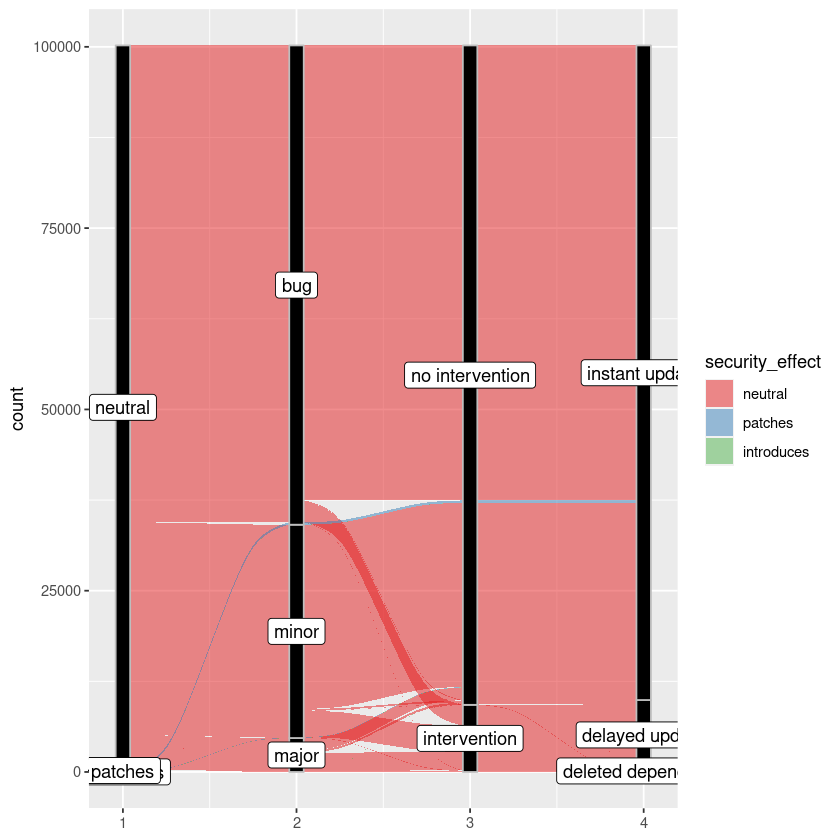

In [89]:
ggplot(alluvial_df,
       aes(y = count, axis1 = security_effect, axis2 = update_type, axis3 = developer_intervention, axis4 = resolution)) +
  geom_alluvium(aes(fill = security_effect), width = 1/12) +
  geom_stratum(width = 1/12, fill = "black", color = "grey") +
  geom_label(stat = "stratum", aes(label = after_stat(stratum))) +
#   scale_x_discrete(limits = c("Gender", "Dept"), expand = c(.05, .05)) +
  scale_fill_brewer(type = "qual", palette = "Set1")

In [15]:
mtcars

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2
Valiant,18.1,6,225.0,105,2.76,3.460,20.22,1,0,3,1
Duster 360,14.3,8,360.0,245,3.21,3.570,15.84,0,0,3,4
Merc 240D,24.4,4,146.7,62,3.69,3.190,20.00,1,0,4,2
Merc 230,22.8,4,140.8,95,3.92,3.150,22.90,1,0,4,2


In [14]:
mtcars %>% make_long(cyl, vs, am, gear, carb)

x,node,next_x,next_node
<fct>,<dbl>,<fct>,<dbl>
cyl,6,vs,0
vs,0,am,1
am,1,gear,4
gear,4,carb,4
carb,4,NA,NA
cyl,6,vs,0
vs,0,am,1
am,1,gear,4
gear,4,carb,4


In [17]:
df

instant_update,update_days,downstream_updated_req,is_intro,is_patch,is_neutral,downstream_package_id,result_category,update_type
<lgl>,<int>,<lgl>,<lgl>,<lgl>,<lgl>,<int64>,<chr>,<pq_pdt_t>
TRUE,0,FALSE,FALSE,FALSE,TRUE,2146078,Ok,bug
TRUE,0,FALSE,FALSE,FALSE,TRUE,2267449,Ok,bug
TRUE,0,FALSE,FALSE,FALSE,TRUE,2267468,Ok,bug
TRUE,0,FALSE,FALSE,FALSE,TRUE,2267466,Ok,bug
TRUE,0,FALSE,FALSE,FALSE,TRUE,2267475,Ok,bug
TRUE,0,FALSE,FALSE,FALSE,TRUE,2267468,Ok,minor
TRUE,0,FALSE,FALSE,FALSE,TRUE,2267472,Ok,bug
TRUE,0,FALSE,FALSE,FALSE,TRUE,2267463,Ok,bug
TRUE,0,FALSE,FALSE,FALSE,TRUE,2267452,Ok,bug
